# Guitar Recording Impulse Response Emulation

This Jupyter Notebook aims to convolute the Cakewalk's FXs chain impulse response and the validation set of the guitar recording.

### Imports

In [6]:
import soundfile as sf
import librosa
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Audio
from scipy.io import wavfile
from scipy import signal

### Before Cakewalk FXs

Creating the impulse to input it in Cakewalk

In [2]:
duration_sec   = 5
sample_rate    = 44100
impulse_signal = signal.unit_impulse(sample_rate * duration_sec)
pcm            = 'PCM_16'
ir_path_dir    = '../datasets/guitar_recording/impulse_and_impulse_response/{}'
sf.write(
    ir_path_dir.format('impulse_44100_16_mono.wav'), 
    impulse_signal, 
    sample_rate, 
    pcm
)

### After getting the FXs impulse response in Cakewalk

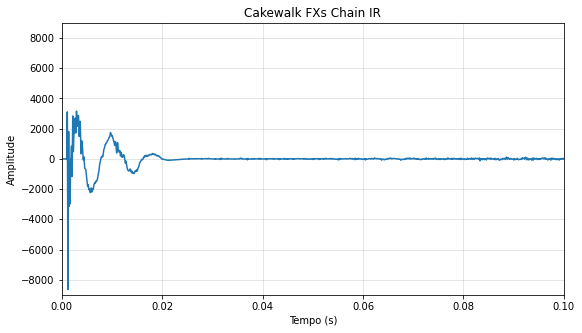

In [8]:
samplerate, ir_signal = wavfile.read(ir_path_dir.format('cakewalk_fxs_chain_impulse_response_44100_16_mono.wav'))

fig = plt.figure(figsize=(9, 5))
plt.plot(np.arange(len(ir_signal))/samplerate, ir_signal)
plt.title('Cakewalk FXs Chain IR')
plt.xlabel('Tempo (s)')
plt.ylabel('Amplitude')
plt.xlim(0, 0.1)
plt.ylim(-9e3, 9e3)
plt.grid(alpha=0.4)
plt.show()

Audio(data=ir_signal, rate=samplerate)

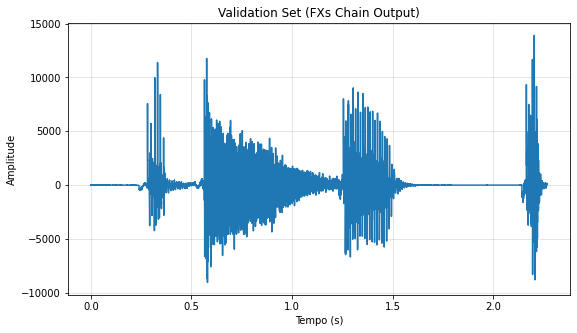

In [37]:
validation_set_path_dir = '../datasets/guitar_recording/validation/{}'
samplerate, validation_signal = wavfile.read(validation_set_path_dir.format('validation_input_44100_16_mono.wav'))

fig = plt.figure(figsize=(9, 5))
plt.plot(np.arange(len(validation_signal[:100000]))/samplerate, validation_signal[:100000])
plt.title('Validation Set (FXs Chain Output)')
plt.xlabel('Tempo (s)')
plt.ylabel('Amplitude')
plt.grid(alpha=0.4)
plt.show()

Audio(data=validation_signal[:100000], rate=samplerate)

In [ ]:
convolution_signal = np.convolve(validation_signal[:100000].astype(np.int64), ir_signal.astype(np.int64), mode='full')[:len(validation_signal[:100000])]

/home/dimitri/.local/lib/python3.8/site-packages/numpy/core/numeric.py:837: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  a, v = array(a, copy=False, ndmin=1), array(v, copy=False, ndmin=1)


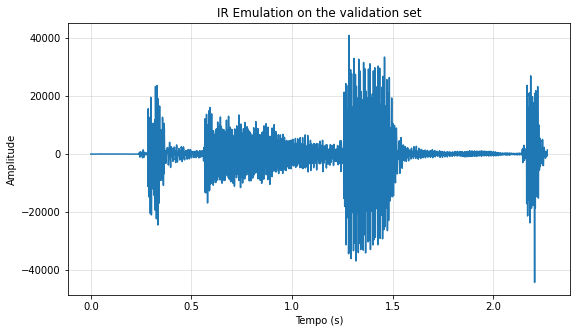

In [45]:
fig = plt.figure(figsize=(9, 5))
plt.plot(np.arange(len(convolution_signal))/samplerate, convolution_signal)
plt.title('IR Emulation on the validation set')
plt.xlabel('Tempo (s)')
plt.ylabel('Amplitude')
plt.grid(alpha=0.4)
plt.show()

Audio(data=convolution_signal, rate=samplerate)

In [48]:
samplerate = 44100
pcm        = 'PCM_16'
sf.write(validation_set_path_dir.format('ir_emulation_validation_output.wav'), convolution_signal, samplerate, pcm)

In [ ]:
import soundfile as sf
import matplotlib.pyplot as plt
import numpy as np
import json
import soundfile as sf
import librosa
from joblib import Parallel, delayed
from scipy import signal
from pathlib import Path
from numpy import random
from IPython.display import Audio
from pedalboard import Pedalboard, Compressor, Chorus, Reverb, Distortion, HighpassFilter, LowpassFilter
from pedalboard.io import AudioFile

In [ ]:
def plot_audio(audio, sr, title):
    fig = plt.figure(figsize=(6, 3))
    plt.plot(np.arange(len(audio))/sr, audio)
    plt.title(title)
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.grid(alpha=0.4)
    plt.show()

def get_random_audio(lst_audio_paths):
    filepath = lst_audio_paths[random.randint(0, len(lst_audio_paths)-1)]
    y, orig_sr = librosa.load(filepath)
    return y, orig_sr, filepath

def convulute_audios(
    fx_name,
    ir_signal,
    samplerate,
    pcm,
    output_dataset_path,
    lst_audio_paths
):
    output_dir = output_dataset_path/fx_name    
    for filepath in lst_audio_paths:
        audio_signal, _ = librosa.load(path=filepath, sr=samplerate)
        convolution_signal = np.convolve(audio_signal, ir_signal, mode='full')[:len(audio_signal)]
        sf.write(output_dir/filepath.name, convolution_signal, samplerate, pcm)

### Initial parameters

In [ ]:
preprocessed_original_dataset_path = Path('../datasets/guitar_chords_v2/preprocessed_original/audio_files/')
output_dataset_path                = Path('../datasets/guitar_chords_v2/impulse_response_emulation/audio_files/')
fx_parameters_path                 = Path('../datasets/guitar_chords_v2/fx/parameters.json')
lst_audio_paths                    = list(preprocessed_original_dataset_path.iterdir())

In [ ]:
with open(fx_parameters_path, mode='r') as f:
    fx_parameters = json.load(f)

samplerate = fx_parameters['samplerate']
pcm        = fx_parameters['pcm']

print(json.dumps(fx_parameters, indent=4))

### Random sample chack and tests

In [ ]:
fx_name = 'HighpassFilter'
params  = fx_parameters['fx'][fx_name]
board   = Pedalboard([eval(fx_name)(**params)])

In [ ]:
impulse_duration_sec = 5
impulse_signal = signal.unit_impulse(samplerate * impulse_duration_sec)

In [ ]:
ir_signal = board(impulse_signal, samplerate)
plot_audio(ir_signal, samplerate, '{} IR'.format(fx_name))
Audio(data=ir_signal, rate=samplerate)

In [ ]:
y, __, filepath = get_random_audio(lst_audio_paths)
plot_audio(y, samplerate, '{} (original)'.format(filepath.name))
Audio(data=y, rate=samplerate)

In [ ]:
convolution_signal = np.convolve(y, ir_signal, mode='full')[:len(y)]
plot_audio(convolution_signal, samplerate, '{} and IR convolution'.format(filepath.name))
Audio(data=convolution_signal, rate=samplerate)

### Generating impulse response and convolutions to each effect

In [ ]:
impulse_wav_filename = '{}_impulse_response.wav'
impulse_duration_sec = 5
impulse_signal       = signal.unit_impulse(samplerate * impulse_duration_sec)
lst_ir_signals       = []

for fx_name, params in fx_parameters['fx'].items():
    board     = Pedalboard([eval(fx_name)(**params)])
    ir_signal = board(impulse_signal.copy(), samplerate)
    lst_ir_signals.append(ir_signal)
    sf.write(output_dataset_path/impulse_wav_filename.format(fx_name), ir_signal, samplerate, pcm)

In [ ]:
Parallel(n_jobs=-1, verbose=100)(
    delayed(convulute_audios)(
        fx_name,
        ir_signal,
        samplerate,
        pcm,
        output_dataset_path,
        lst_audio_paths
    ) for fx_name, ir_signal in zip(fx_parameters['fx'].keys(), lst_ir_signals)
)

Non parallel version bellow. Keep commented.

In [ ]:
# impulse_wav_filename = '{}_impulse_response.wav'
# impulse_duration_sec = 5
# impulse_signal       = signal.unit_impulse(samplerate * impulse_duration_sec)

# for fx_name, params in fx_parameters['fx'].items():
    
#     print('{}...'.format(fx_name), end=' ')

#     board     = Pedalboard([eval(fx_name)(**params)])
#     ir_signal = board(impulse_signal.copy(), samplerate)
#     sf.write(output_dataset_path/impulse_wav_filename.format(fx_name), ir_signal, samplerate, pcm)
    
#     output_dir = output_dataset_path/fx_name
#     if not output_dir.is_dir():
#         output_dir.mkdir()
    
#     for filepath in lst_audio_paths:
#         with AudioFile(str(filepath)) as f:
#             audio_signal = f.read(f.frames)
#         convolution_signal = np.convolve(np.squeeze(audio_signal), ir_signal, mode='full')[:len(audio_signal)]
#         sf.write(output_dir/filepath.name, convolution_signal, samplerate, pcm)
        
#     print('OK')